In [1]:
%load_ext autoreload
%autoreload 2


# Build a baseline model

We are interested in testing the following alternative hypothesis:
1. Higher square footage increases home sale price.
2. The house filling a higher proportion of the overall lot decreases home sale price
3. The cost per square foot is lower in duplexes than in single-family homes

Therefore we have decided that our baseline model should include the following features:
1. Total living space, squarefeet
2. Total lot size, squarefeet
3. The ratio of house footprint to lot size. To engineer this feature we assumed the footprint was reasonably represented by the attached garage space+the first floor square feet divided by the lot size. 
4. If the house is a duplex, or not


## Cleaning Thought Process

Some top level thoughts are: we removed sales below 10,000 USD, as these are most likely erroneous or a result from a sale from family to family. There are some mobile homes in the 30,000-50,000 USD range, and so we decided to err on the lower side as perhaps there are legitimate sales in the 10,000-20,000 USD range. 

Also due to our business goals, of helping millennials buy their first home, we removed saleprices outside of two standard deviations of the mean. This excluded houses sold for more than 2.5 million USD. Our reasoning being that houses beyond that are certainly well outside the ability of a first-time buyer to achieve.

In [2]:
from src.utilities import kc_housing as kc
df = kc.pullsqldata()
df_clean = kc.clean_data_intial(df)
x = df_clean.drop(columns = 'saleprice')
y = df_clean['saleprice']

In [3]:
baseline_features = ['sqfttotliving','sqftlot','footprint_ratio','duplex']
kc.make_housing_model(baseline_features, x, y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     3228.
Date:                Thu, 05 Dec 2019   Prob (F-statistic):               0.00
Time:                        17:57:11   Log-Likelihood:            -3.9009e+05
No. Observations:               27813   AIC:                         7.802e+05
Df Residuals:                   27808   BIC:                         7.802e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.884e+05   6113.559     30.822      0.000    1.76e+05       2e+05
sqfttotliving     226.2975      2.124    106.536      0.000     222.134     230.461
sqftlot            -0.2127      0.158     -1.344      0.179      -0.523       0.097
footprint_ratio  2.631e+05   1.77e+04     14.843      0.000    2.28e+05    2.98e+05
duplex            6.61e+04   1.62e+04      4.074      0.000    3.43e+04    9.79e+04
==============================================================================
Omnibus:                     3237.057   Durbin-Watson:                   0.869
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6388.669
Skew:                           0.749   Prob(JB):                         0.00
Kurtosis:                       4.807   Cond. No.                     1.78e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.78e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Check baseline model assumptions

In [ ]:
kc.check_feature_linearity(baseline_features, x, y)

In [ ]:
kc.check_feature_resid_dist(baseline_features, x, y)

In [ ]:
kc.check_feature_heteros(baseline_features, x, y)

### Because the sqftlot feature seems to violoate assumption of linearity, lets remove it from the model

In [ ]:
baseline_features = ['sqfttotliving','footprint_ratio','duplex']
kc.make_housing_model(baseline_features, x, y)

# All RE listings include bath count, so lets see how that contributes to our model:

In [ ]:
list_of_feat =['bath_total_count', 'sqfttotliving','footprint_ratio','duplex']
kc.make_housing_model(list_of_feat,kc.engineer_total_baths(x),y)

### Total bathrooms does not seem to add much benefit to our model, and it has an elevated p score, so we will not include it in our model. 

# What about the age of the house?

In [ ]:
list_of_feat =['sqfttotliving','footprint_ratio','duplex', 'age']
kc.make_housing_model(list_of_feat,kc.engineer_age(x),y)

### Age seems to add a notible boost in the model,and it has a low p score, lets test its assumptions:

In [ ]:
kc.check_feature_heteros(['age'],x,y)
kc.check_feature_linearity(['age'],x,y)
kc.check_feature_resid_dist(['age'],x,y)

### It appears that age violates the assumption of linearity, so although it adds some strength to out R^2 value, we will leave it out of our improved model. 

# What about porches/decks?

In [ ]:
list_of_feat =['sqfttotliving','footprint_ratio','duplex', 'porch_sqft_total']
kc.make_housing_model(list_of_feat,kc.engineer_total_porch_space(x),y)

The R^2 value remains unchanged, and the porch feature's coefficient is relativley small, so we will not include it in the model. 

### Once again, it seems the porch space violates the assumption of linearity, so we will not include it in our final model. 

# How about zipcode? 

In [ ]:
#create model with zipcodes and other baseline features

list_of_feat =['sqfttotliving','footprint_ratio','duplex']
kc.make_zipcode_model(df_clean, list_of_feat)

### LOCATION LOCATION LOCATION wow, that added a bunch to our R^2! Lets check the assumptions: 

In [ ]:
kc.check_zip_code_res_normality(df_clean)


Great, Zip Codes seem to meet our assumptions, lets include them !

# We now added features relating to views, the best predicting waterfront feature, as well as heatsource and the surface of the access street

We tried a model with ALL features not dropped by our cleaning function, and a few stood out. We wanted to explore the street surface and heatsource features, as they were categorical. Upon looking closely at them, they didn't actually improve our R^2 when added alongside the view and waterfront features. And when dropping them, they did not decrease our ability to predict

We did not include some view features based on assumptions and correlation. For example, houses in King County that have views of Pugent Sound are expected to also have views of the Olympics. The Olympics proved to be a better predictor so we used that instead of the Puget Sound feature. The values for all of the view features are continuous, no view is 0, fair is 1, excellent is 4.


In [4]:
## This is our list of features for the new model
new_model = df_clean[['saleprice','sqfttotliving', 'footprint_ratio', 'duplex', 'wfntlocation', 'lakesammamish', 'seattleskyline', 'olympics', 'mtrainier', 'streetsurface', 'heatsource', 'zipcode']]

In [5]:
# this one hot encodes the zipcode column
zip_df = kc.zip_code_df(new_model)[0]

/Users/tree/ds/proj2/king_county_housing/src/utilities/kc_housing.py:281: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dropped_rows['zipcode'] = dropped_rows['zipcode'].map(lambda x: x[0:5])


In [27]:
import statsmodels.api as sm
Y = zip_df['saleprice']
X = zip_df.drop(['saleprice', 'streetsurface', 'heatsource'], axis=1)
X_int = sm.add_constant(X)
model = sm.OLS(Y, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     649.7
Date:                Thu, 05 Dec 2019   Prob (F-statistic):               0.00
Time:                        18:07:19   Log-Likelihood:            -3.0923e+05
No. Observations:               22804   AIC:                         6.186e+05
Df Residuals:                   22714   BIC:                         6.194e+05
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            7.349e+05   1.88e+05      3.911      0.000    3.67e+05     1.1e+06
sqfttotliving     191.4709      1.672    114.537      0.000     188.194     194.748
footprint_ratio -1.069e+05   1.33e+04     -8.031      0.000   -1.33e+05   -8.08e+04
duplex          -9223.4056   1.06e+04     -0.873      0.382   -2.99e+04    1.15e+04
wfntlocation     2.119e+04   1515.878     13.982      0.000    1.82e+04    2.42e+04
lakesammamish     1.05e+05   8108.962     12.945      0.000    8.91e+04    1.21e+05
seattleskyline   3.593e+04   6948.406      5.171      0.000    2.23e+04    4.95e+04
olympics         6.511e+04   3415.093     19.066      0.000    5.84e+04    7.18e+04
mtrainier        2.242e+04   5674.629      3.950      0.000    1.13e+04    3.35e+04
zip_98001       -7.057e+05   1.88e+05     -3.754      0.000   -1.07e+06   -3.37e+05
zip_98002       -6.921e+05   1.88e+05     -3.680      0.000   -1.06e+06   -3.23e+05
zip_98003       -6.949e+05   1.88e+05     -3.695      0.000   -1.06e+06   -3.26e+05
zip_98004        2.113e+05   1.89e+05      1.121      0.262   -1.58e+05    5.81e+05
zip_98005       -1.867e+04   1.89e+05     -0.099      0.921   -3.88e+05    3.51e+05
zip_98006       -1.608e+05   1.88e+05     -0.855      0.393   -5.29e+05    2.08e+05
zip_98007       -2.236e+05   1.89e+05     -1.186      0.236   -5.93e+05    1.46e+05
zip_98008       -2.634e+05   1.88e+05     -1.400      0.161   -6.32e+05    1.05e+05
zip_98009       -6.705e+05   2.66e+05     -2.524      0.012   -1.19e+06    -1.5e+05
zip_98010        -6.11e+05   1.89e+05     -3.237      0.001   -9.81e+05   -2.41e+05
zip_98011       -4.361e+05   1.88e+05     -2.316      0.021   -8.05e+05    -6.7e+04
zip_98014       -5.309e+05   1.89e+05     -2.814      0.005   -9.01e+05   -1.61e+05
zip_98019       -5.396e+05   1.88e+05     -2.863      0.004   -9.09e+05    -1.7e+05
zip_98022       -6.802e+05   1.88e+05     -3.615      0.000   -1.05e+06   -3.11e+05
zip_98023       -7.059e+05   1.88e+05     -3.755      0.000   -1.07e+06   -3.37e+05
zip_98024        -5.17e+05    1.9e+05     -2.725      0.006   -8.89e+05   -1.45e+05
zip_98027        -3.44e+05   1.88e+05     -1.828      0.068   -7.13e+05    2.48e+04
zip_98028        -4.62e+05   1.88e+05     -2.455      0.014   -8.31e+05   -9.31e+04
zip_98029       -2.612e+05   1.88e+05     -1.387      0.165    -6.3e+05    1.08e+05
zip_98030       -6.687e+05   1.88e+05     -3.554      0.000   -1.04e+06      -3e+05
zip_98031       -6.632e+05   1.88e+05     -3.526      0.000   -1.03e+06   -2.94e+05
zip_98032       -6.811e+05   1.88e+05     -3.618      0.000   -1.05e+06   -3.12e+05
zip_98033       -1.039e+04   1.88e+05     -0.055      0.956   -3.79e+05    3.58e+05
zip_98034       -3.362e+05   1.88e+05     -1.788      0.074   -7.05e+05    3.23e+04
zip_98038       -6.214e+05   1.88e+05     -3.306      0.001

### That really added some predictability to the model! 
### Adjusted R^2 = 0.717

Now we need to test the assumptions of these new features

//anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
//anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


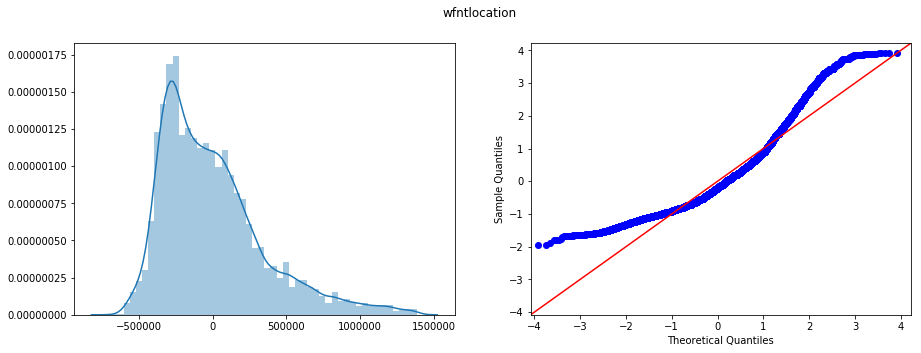

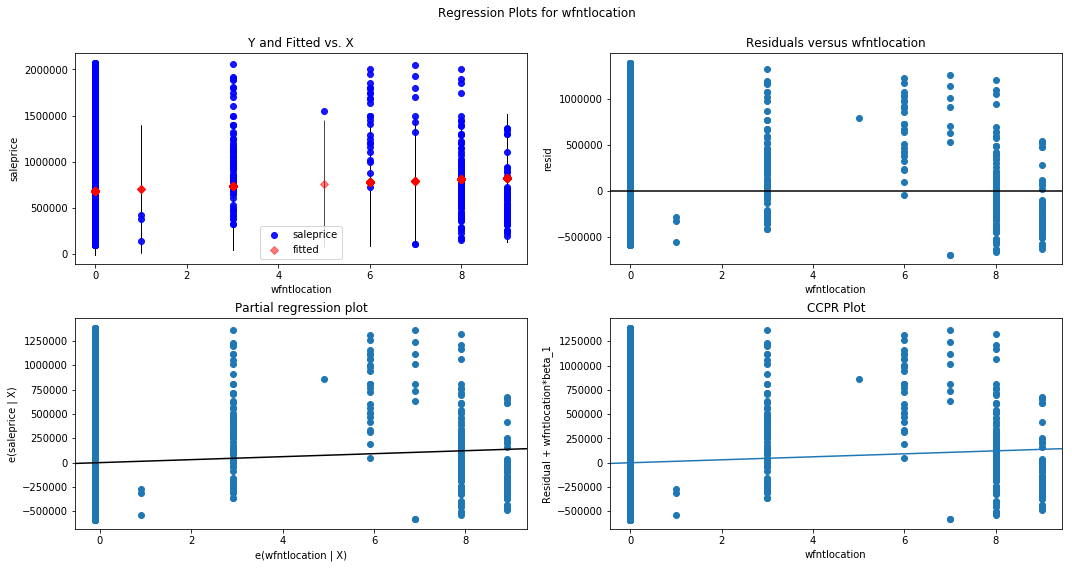

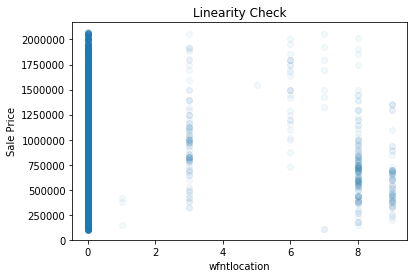

In [18]:
#Waterfront Location Assumption Tests = Passed
kc.check_feature_resid_dist(['wfntlocation'],X, Y)
kc.check_feature_heteros(['wfntlocation'], X, Y)
kc.check_feature_linearity(['wfntlocation'], X, Y)

//anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
//anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


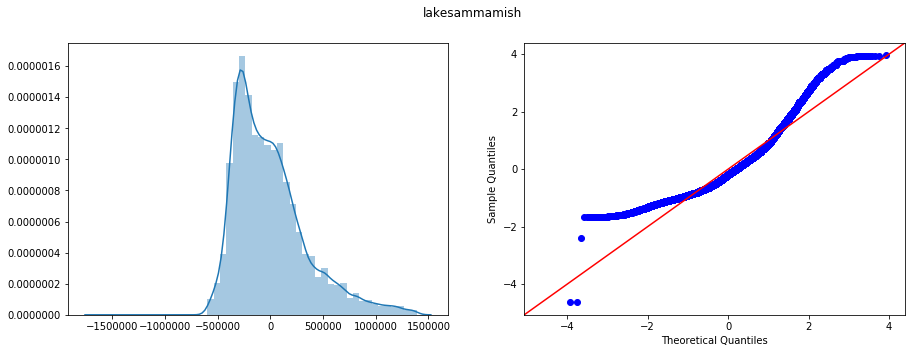

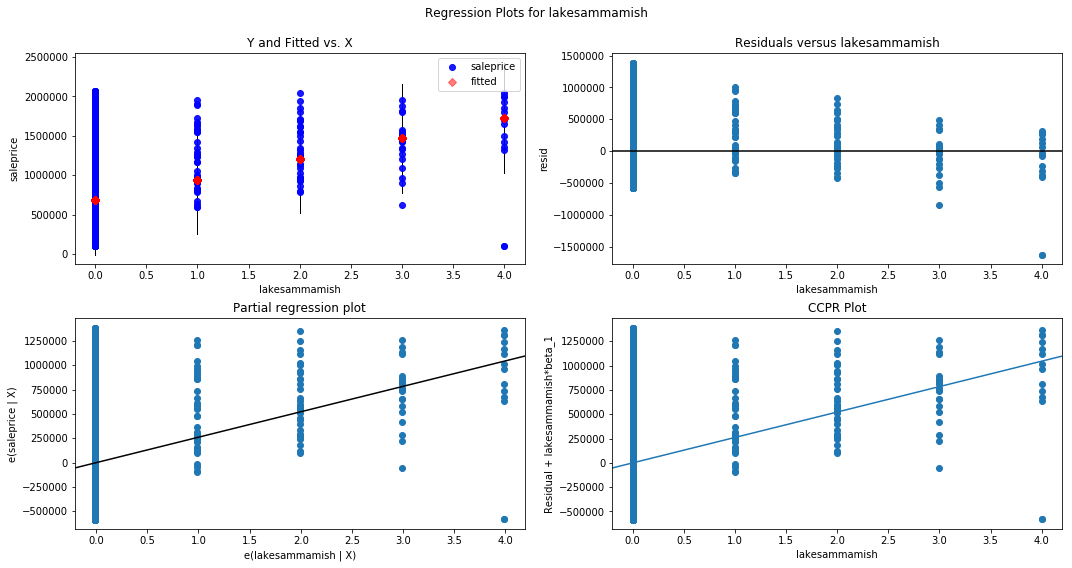

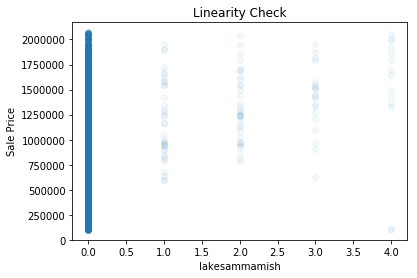

In [20]:
kc.check_feature_resid_dist(['lakesammamish'],X, Y)
kc.check_feature_heteros(['lakesammamish'], X, Y)
kc.check_feature_linearity(['lakesammamish'], X, Y)

//anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
//anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


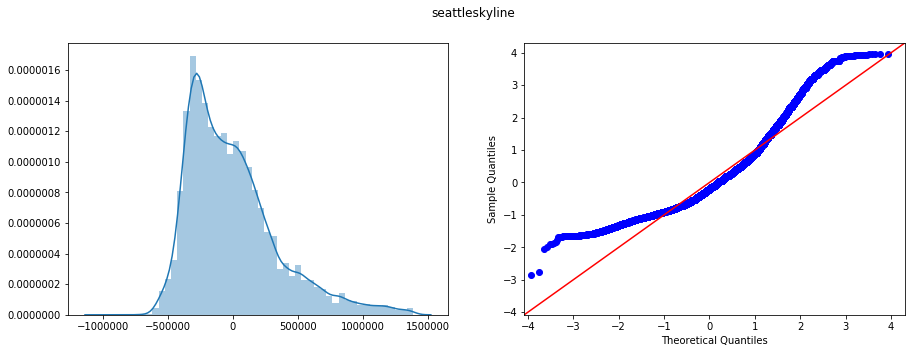

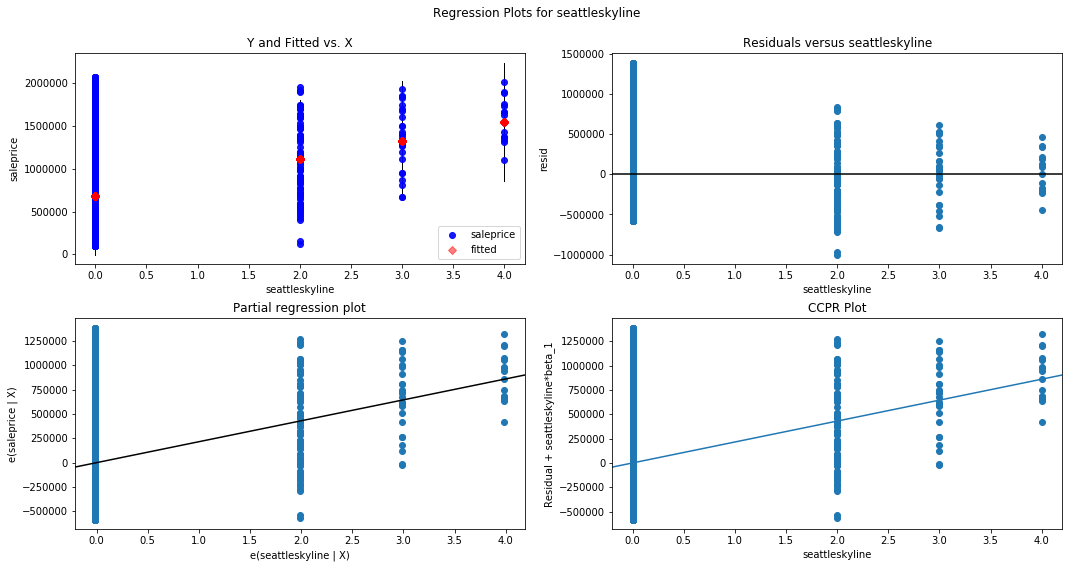

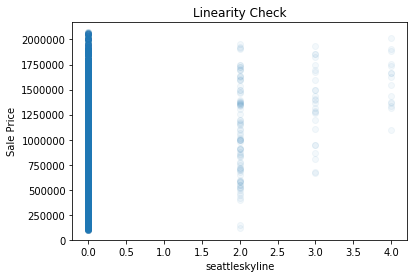

In [21]:
kc.check_feature_resid_dist(['seattleskyline'],X, Y)
kc.check_feature_heteros(['seattleskyline'], X, Y)
kc.check_feature_linearity(['seattleskyline'], X, Y)

//anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
//anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


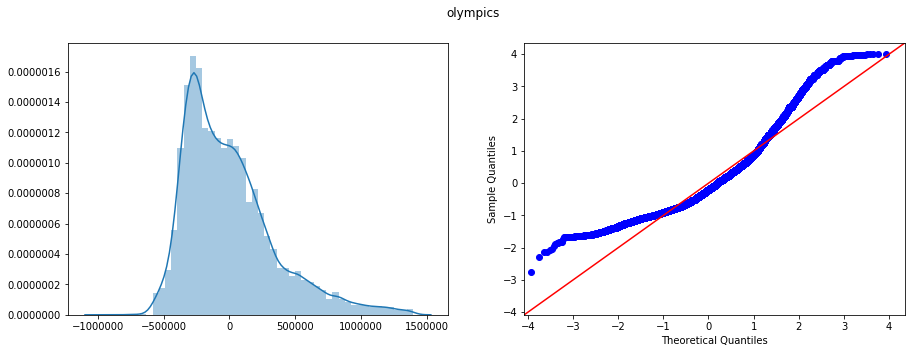

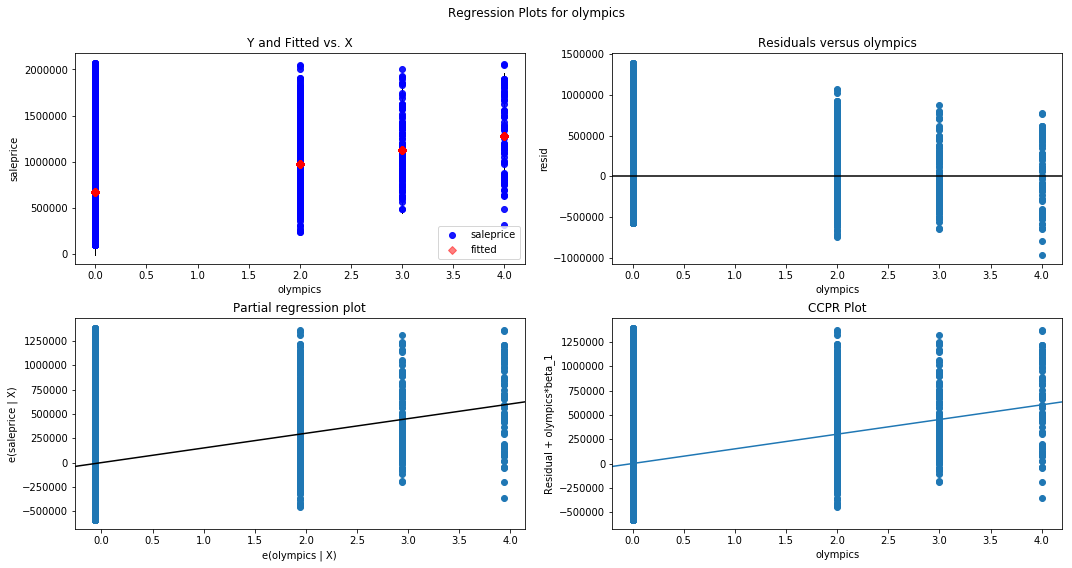

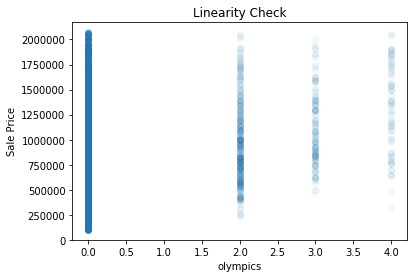

In [22]:
kc.check_feature_resid_dist(['olympics'],X, Y)
kc.check_feature_heteros(['olympics'], X, Y)
kc.check_feature_linearity(['olympics'], X, Y)

//anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
//anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


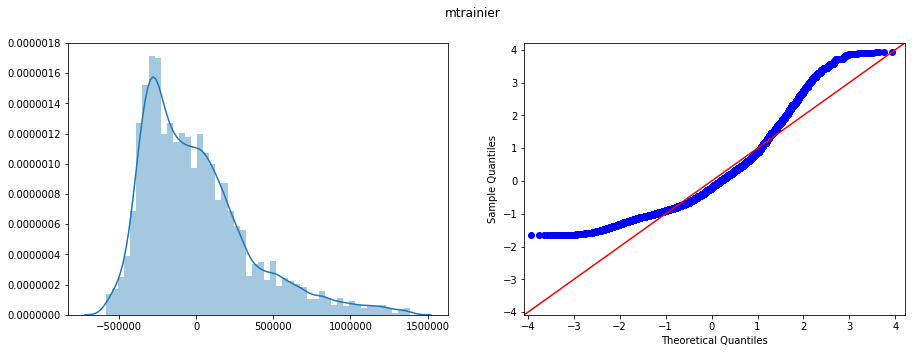

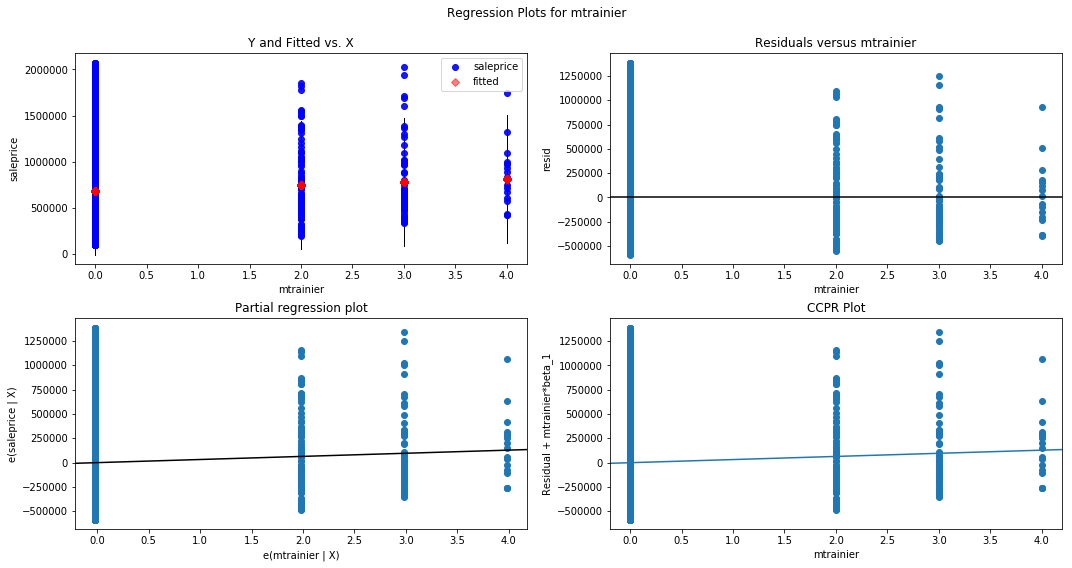

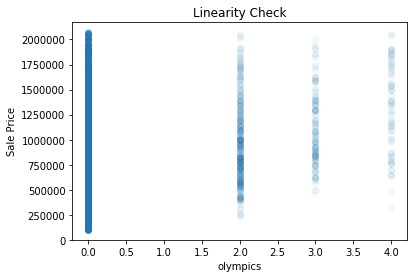

In [23]:
kc.check_feature_resid_dist(['mtrainier'],X, Y)
kc.check_feature_heteros(['mtrainier'], X, Y)
kc.check_feature_linearity(['olympics'], X, Y)

In [25]:
X['wfntlocation'].value_counts()

0.0    22472
8.0      138
3.0       87
9.0       68
6.0       26
7.0        9
1.0        3
5.0        1
Name: wfntlocation, dtype: int64